In [1]:
# RNN - LSTM for time-series forecasting
# partly follows blog https://machinelearningmastery.com/introduction-to-time-series-forecasting-with-python/

from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot as plt
from numpy import array

# trajectory matrix for solving supervized learning task
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # входящая последовательность (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # прогнозируемая последовательность (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    agg = concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg


# diffential series interval
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)


# train / test splitting
def prepare_data(series, n_test, n_lag, n_seq):
    raw_values = series.values
    diff_series = difference(raw_values, 1)
    diff_values = diff_series.values
    diff_values = diff_values.reshape(len(diff_values), 1)
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled_values = scaler.fit_transform(diff_values)
    scaled_values = scaled_values.reshape(len(scaled_values), 1)
    supervised = series_to_supervised(scaled_values, n_lag, n_seq)
    supervised_values = supervised.values
    train, test = supervised_values[0:-n_test], supervised_values[-n_test:]
    return scaler, train, test


# fit an LSTM network
def fit_lstm(train, n_lag, n_seq, n_batch, nb_epoch, n_neurons):
    # reshape training into [samples, timesteps, features]
    X, y = train[:, 0:n_lag], train[:, n_lag:]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()

    # stateful = True - keep state in memory;

    model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(y.shape[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    history_loss=[]
    history_val_loss=[]
    for i in range(nb_epoch):
        print(i)
        hist = model.fit(X, y, validation_split=0.1,epochs=1, batch_size=n_batch, verbose=1, shuffle=False)
        history_loss.append(hist.history['loss'])
        history_val_loss.append(hist.history['val_loss'])
    print(model.summary())
    return model,history_loss,history_val_loss

# 1 step of forecasting
def forecast_lstm(model, X, n_batch):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, len(X))
    # make forecast
    forecast = model.predict(X, batch_size=n_batch)
    # convert to array
    return [x for x in forecast[0, :]]

# Forecasting
def make_forecasts(model, n_batch, train, test, n_lag, n_seq):
    forecasts = list()
    for i in range(len(test)):
        X, y = test[i, 0:n_lag], test[i, n_lag:]
        # make forecast
        forecast = forecast_lstm(model, X, n_batch)
        # store the forecast
        forecasts.append(forecast)
    return forecasts

#  inverse_difference
def inverse_difference(last_ob, forecast):
    # invert first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # propagate difference forecast using inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted

# inverse transformation
def inverse_transform(series, forecasts, scaler, n_test):
    inverted = list()
    for i in range(len(forecasts)):
    # create array from forecast
        forecast = array(forecasts[i])
        forecast = forecast.reshape(1, len(forecast))
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        index = len(series) - n_test + i - 1
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        # store
        inverted.append(inv_diff)
    return inverted

<ipython-input-1-008590b9a1a1>:7: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


<ipython-input-5-143b7f27a949>:2: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  data = pd.read_csv('/content/drive/My Drive/AMLT 2023/AMLT-01 - Time Series Analysis/WAG_C_M.csv',';', index_col=['month'], parse_dates=['month'], dayfirst=True,encoding='cp1251')


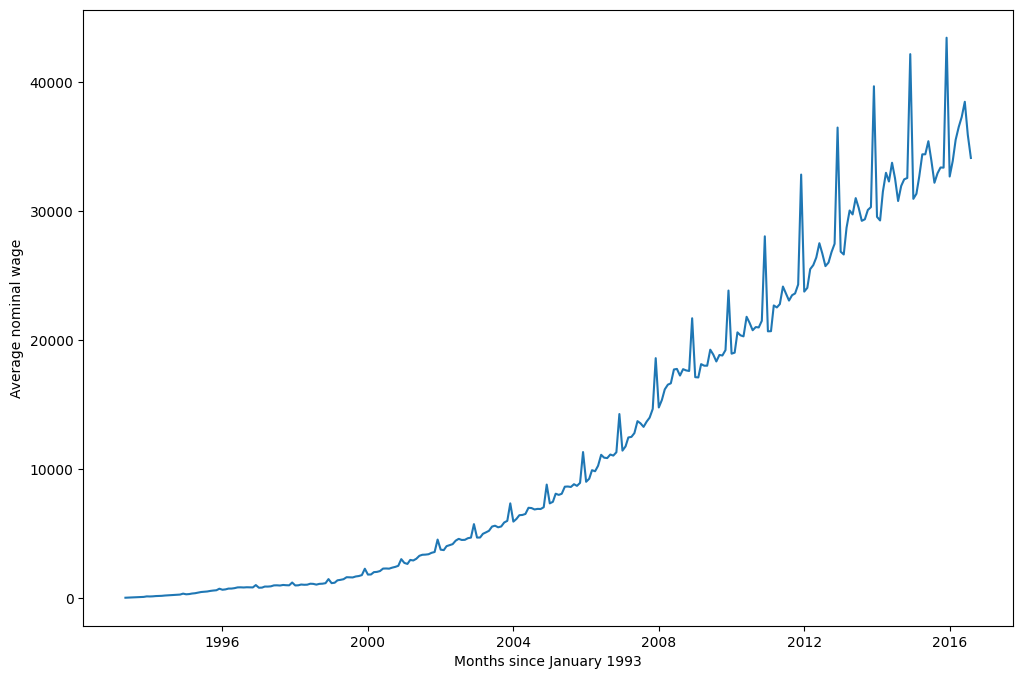

In [5]:
# Data
data = pd.read_csv('/content/drive/My Drive/AMLT 2023/AMLT-01 - Time Series Analysis/WAG_C_M.csv',';', index_col=['month'], parse_dates=['month'], dayfirst=True,encoding='cp1251')
plt.figure(figsize=(12,8))
plt.plot(data)
plt.ylabel('Average nominal wage')
plt.xlabel('Months since January 1993')
plt.show()

In [8]:
# trajectory matrix

d1 = series_to_supervised(data, n_in=12, n_out=6, dropnan=True)
d1

,var1(t-12),var1(t-11),var1(t-10),var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t),var1(t+1),var1(t+2),var1(t+3),var1(t+4),var1(t+5)
month,,,,,,,,,,,,,,,,,,
1994-05-01,37.5,47.4,56.0,65.4,80.9,93.0,101.5,141.2,134.2,144.7,164.8,171.5,183.5,207.5,221.0,232.8,253.2,265.0
1994-06-01,47.4,56.0,65.4,80.9,93.0,101.5,141.2,134.2,144.7,164.8,171.5,183.5,207.5,221.0,232.8,253.2,265.0,281.6
1994-07-01,56.0,65.4,80.9,93.0,101.5,141.2,134.2,144.7,164.8,171.5,183.5,207.5,221.0,232.8,253.2,265.0,281.6,354.2
1994-08-01,65.4,80.9,93.0,101.5,141.2,134.2,144.7,164.8,171.5,183.5,207.5,221.0,232.8,253.2,265.0,281.6,354.2,302.6
1994-09-01,80.9,93.0,101.5,141.2,134.2,144.7,164.8,171.5,183.5,207.5,221.0,232.8,253.2,265.0,281.6,354.2,302.6,321.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-11-01,32546.0,42136.0,30929.0,31325.0,32642.0,34377.0,34380.0,35395.0,33901.0,32176.0,32911.0,33357.0,33347.0,43408.0,32660.0,33873.0,35501.0,36497.0
2015-12-01,42136.0,30929.0,31325.0,32642.0,34377.0,34380.0,35395.0,33901.0,32176.0,32911.0,33357.0,33347.0,43408.0,32660.0,33873.0,35501.0,36497.0,37270.0
2016-01-01,30929.0,31325.0,32642.0,34377.0,34380.0,35395.0,33901.0,32176.0,32911.0,33357.0,33347.0,43408.0,32660.0,33873.0,35501.0,36497.0,37270.0,38447.0


In [25]:
# hyperparameters initialization and training of the model

# historical lag - multiple of 12 - length of the input vector
n_lag = 12   # 24, 36
# forecasting period
n_seq = 24
# number of test samples
n_test = 8
# number of epochs for training
n_epochs = 30
# batch size
n_batch = 1
# number of LSTM cells
n_neurons =  12

# dataset preparation
scaler, train, test = prepare_data(data, n_test, n_lag, n_seq)
# train the model
model,history_loss,history_val_loss = fit_lstm(train, n_lag, n_seq, n_batch, n_epochs, n_neurons)
# make forecasts for n_seq steps
forecasts = make_forecasts(model, n_batch, train, test, n_lag, n_seq)
# inverse scaling
forecasts = inverse_transform(data, forecasts, scaler, n_test+2)


0
212/212 [==============================] - 4s 6ms/step - loss: 0.0218 - val_loss: 0.1425
1
212/212 [==============================] - 0s 2ms/step - loss: 0.0205 - val_loss: 0.1338
2
212/212 [==============================] - 1s 2ms/step - loss: 0.0190 - val_loss: 0.1193
3
212/212 [==============================] - 1s 2ms/step - loss: 0.0164 - val_loss: 0.0976
4
212/212 [==============================] - 1s 3ms/step - loss: 0.0130 - val_loss: 0.0772
5
212/212 [==============================] - 1s 3ms/step - loss: 0.0104 - val_loss: 0.0631
6
212/212 [==============================] - 1s 2ms/step - loss: 0.0087 - val_loss: 0.0519
7
212/212 [==============================] - 1s 2ms/step - loss: 0.0074 - val_loss: 0.0434
8
212/212 [==============================] - 1s 2ms/step - loss: 0.0063 - val_loss: 0.0365
9
212/212 [==============================] - 1s 3ms/step - loss: 0.0054 - val_loss: 0.0306
10
212/212 [==============================] - 1s 3ms/step - loss: 0.0046 - val_loss: 0.025

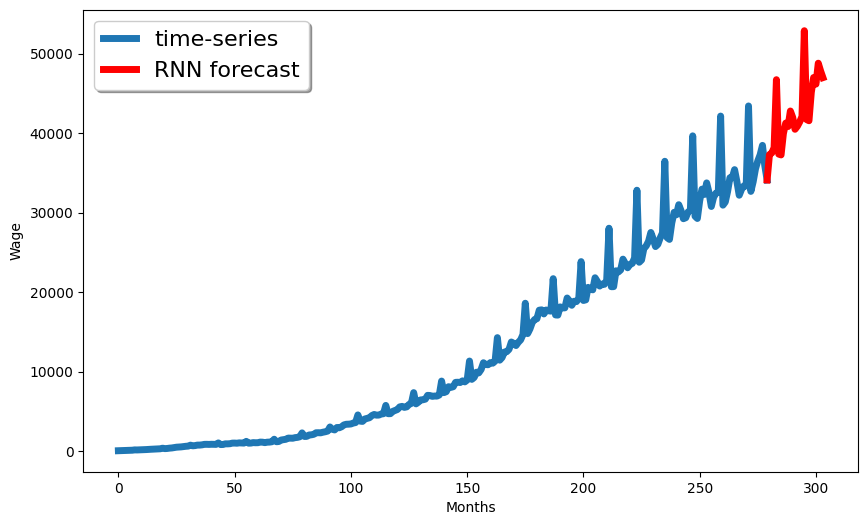

In [26]:
# visualize

fig=plt.figure(figsize=(10,6))
plt.plot(data.values[:],linewidth=5)
off_s = len(data) - n_test +len(forecasts)  - 1
off_e = off_s + len(forecasts[0]) + 1
xaxis = [x for x in range(off_s, off_e)]
yaxis = [data.values[off_s]] + forecasts[-1]
plt.plot(xaxis, yaxis, color='r',linewidth=5)

plt.ylabel('Wage')
plt.xlabel('Months')

plt.legend(('time-series', 'RNN forecast'),
           shadow=True, loc='upper left', handlelength=1.5, fontsize=16)
plt.show()


[0.0009727315045893192] [0.003973298240453005]


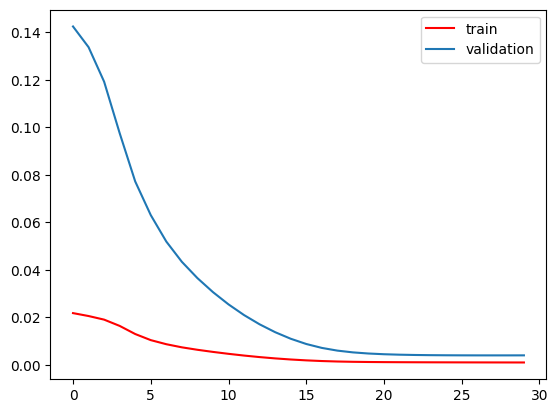

In [27]:
# Loss functions for val and train sets

plt.plot(history_loss, 'r',label='train')
plt.plot(history_val_loss,label='validation')
plt.legend()
print(history_loss[-1],history_val_loss[-1])